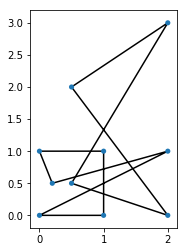

In [9]:
import matplotlib.pyplot as plt

% matplotlib inline

def show_polygons(ax, polygons, face_color='white', alpha=1):
    from matplotlib.patches import Polygon, Circle
    patches = []

    if isinstance(face_color, list):
        def get_face_color():
            np.random.shuffle(face_color)
            return face_color[0]
    else:
        def get_face_color():
            return face_color

    for vertices in polygons:
        polygon = Polygon(
            vertices,
            alpha=alpha, 
            ec='black',
            fc=get_face_color(),
            lw=1.5)
        patches.append(polygon)
        for vertex in vertices:
            circle = Circle(vertex, 0.04)
            patches.append(circle)

    for patch in patches:
        ax.add_patch(patch)

    ax.autoscale()
    ax.set_aspect('equal')

fig, ax = plt.subplots()

a = [[0, 0], [1, 0], [1, 1], [0, 1], [0.2, 0.5], [2, 1]]
b = [[0.5, 2], [2, 0], [0.5, 0.5], [2, 3]]
show_polygons(ax, [a, b], 'none')

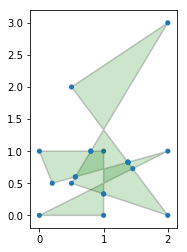

In [10]:
import numpy as np 
import copy

def to_gh_point(x, y):
    return {'x': x, 'y': y}

def to_gh_polygon(poly):
    first = None
    current = first
    for x, y in poly:
        if first is None:
            current = first = to_gh_point(x, y)
        else:
            current['next'] = to_gh_point(x, y)
            current = current['next']
    current['next'] = first
    current['end'] = True
    return first

def intersect(p1, p2, q1, q2):
    p1, p2, q1, q2 = map(np.array, [p1, p2, q1, q2])
    wec_p1 = np.cross(p1 - q1, q2 - q1)
    wec_p2 = np.cross(p2 - q1, q2 - q1)
    if wec_p1 * wec_p2 < 0:
        wec_q1 = np.cross(q1 - p1, p2 - p1)
        wec_q2 = np.cross(q2 - p1, p2 - p1)
        if wec_q1 * wec_q2 < 0:
            p_alpha = wec_p1 / (wec_p1 - wec_p2)
            q_alpha = wec_q1 / (wec_q1 - wec_q2)
            return True, p_alpha, q_alpha
    return False, None, None

def vertex_iter(poly):
    while True:
        yield poly
        if 'end' in poly:
            break
        else:
            poly = poly['next']
            
def get_point_from_gh_vertex(vertex):
    return vertex['x'], vertex['y']
            
def vertex_xy_iter(poly):
    return map(lambda v: get_point_from_gh_vertex(v), vertex_iter(poly))
        
def create_vertex(p1, p2, alpha):
    p1, p2 = map(np.array, [p1, p2])
    x, y = p1 + (p2 - p1) * alpha
    return to_gh_point(x, y)

def get_xys(gh):
    return list(vertex_xy_iter(gh))

def phase_one(s, c):
    s = copy.deepcopy(s)
    c = copy.deepcopy(c)
   
    cur_s = s
    cur_c = c
    while True:
        cur_c = c
        while True:
            p1, p2 = map(get_point_from_gh_vertex, [cur_s, cur_s['next']])
            q1, q2 = map(get_point_from_gh_vertex, [cur_c, cur_c['next']])
            b, p_alpha, q_alpha = intersect(p1, p2, q1, q2)
            
            if b:
                si = create_vertex(p1, p2, p_alpha)
                ci = create_vertex(q1, q2, q_alpha)
                
                si['neighbor'] = ci
                ci['neighbor'] = si
                
                si['next'] = cur_s['next']
                cur_s['next'] = si
                
                ci['next'] = cur_c['next']
                cur_c['next'] = ci
            
            if 'end' in cur_c:
                break
            cur_c = cur_c['next']
            
        if 'end' in cur_s:
            break            
        cur_s = cur_s['next']

    return s, c

gh_a = to_gh_polygon(a)
gh_b = to_gh_polygon(b)

gh_a1, gh_b1 = phase_one(gh_a, gh_b)

fig, ax = plt.subplots()
show_polygons(ax, map(get_xys, [gh_a1, gh_b1]), 'green', 0.2)